# 1-Install & Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# We have to install the environment library using the line below:
!pip install highway-env

# Also, we have to install some useful libraries for our project:
!pip install moviepy --upgrade
!pip install -q mediapy

In [ ]:
# Import libraries:
import highway_env
from highway_env import utils
from highway_env.envs.common.abstract import AbstractEnv, MultiAgentWrapper
from highway_env.road.lane import AbstractLane, CircularLane, LineType, StraightLane
from highway_env.road.regulation import RegulatedRoad
from highway_env.road.road import Road, RoadNetwork
from highway_env.vehicle.kinematics import Vehicle
from highway_env.vehicle.behavior import IDMVehicle
from typing import Dict, List, Optional, Text, Tuple, TypeVar
import time
import resource
import gym
import pygame
import json
import os
import os.path
import base64, io
import glob
import numpy as np
import pandas as pd
import random
from itertools import count
from PIL import Image
from collections import deque, namedtuple
from scipy.stats import norm , t
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
# Pytorch librearies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
# For visualization
import tempfile
import cv2
from google.colab.patches import cv2_imshow
from gym import error, logger
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import itertools
import math
from moviepy.editor import VideoFileClip
import mediapy as media
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import importlib
from pprint import pprint

def check_library_versions(libraries):
    """
    Checks and prints the versions of the given libraries in a formatted table.
    """
    print("The version of each installed library:")
    print("{:<30} {:<15}".format("Library", "Version"))
    print("-" * 45)

    for lib in libraries:
        try:
            module = importlib.import_module(lib)
            version = getattr(module, '__version__', 'Version not available')
            print("{:<30} {:<15}".format(lib, version))
        except ImportError:
            print("{:<30} {:<15}".format(lib, "Failed to import"))

    print("-" * 45)

# List of libraries for which we want to check the version
libraries = [
    "highway_env", "gym", "pygame", "numpy", "pandas", "matplotlib",
     "PIL.Image", "tqdm", "torch", "IPython", "cv2"
]
# Let's check the version of each imported library:
check_library_versions(libraries)


# **2-Create the environment**

## 2.1- Implementing the Intersection Environment




In [297]:
class IntersectionEnv(AbstractEnv):
    ACTIONS: Dict[int, str] = {0: "SLOWER", 1: "IDLE", 2: "FASTER"}
    ACTIONS_INDEXES = {v: k for k, v in ACTIONS.items()}

    def __init__(self, config: dict = None, render_mode: Optional[str] = None) -> None:
      super().__init__()
      self.initial_route = None


    @classmethod
    def default_config(cls) -> dict:
        """
        Returns the default configuration for the environment.

        This function returns a dictionary with the default configuration for the environment.
        It inherits and extends the default configuration from the parent class.
        """
        # Inherit and extend the default configuration from the parent class.
        config = super().default_config()
        # Update the configuration dictionary with environment-specific settings.
        config.update(
            {
                #---------------------------------------------------------------
                # Configuration for observation settings
                "observation": {

                    # The KinematicObservation is a V x F array that describes a list of V nearby vehicles by a set of features of size F, listed in the "features" configuration field.
                    "type": "Kinematics",

                    #Number of observed vehicles
                    "vehicles_count": 2,

                    # Names of features used in the observation
                    "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],

                    # Presence:
                    #     - A binary feature to indicate whether an agent is present at a given location or not.
                    #     - 0 mean no agent is present

                    # Position:
                    #     - x: the position of the ego vehicle on the x-axis. (It can also show how far the vehicle is from a reference point on this axis.)
                    #     - y: the position of the ego vehicle on the y-axis. (It can also show how far the vehicle is from a reference point on this axis.)

                    # Velocity (Speed):
                    #     - vx: Velocity on the x-axis of vehicle. (Longitudinal speed)
                    #     - vy: Velocity on the y-axis of vehicle. (Lateral speed)

                    # Heading (Heading of vehicle):
                    #     - cos_h: This is the cosine of the vehicle's heading, which can help determine its direction in trigonometric terms.
                    #     - sin_h: This is the sine of the vehicle's heading, another way to describe its direction using trigonometry.

                    # a dict mapping a feature name to [min, max] values
                    "features_range": {
                        "x": [-100, 100],
                        "y": [-100, 100],
                        "vx": [-20, 20],
                        "vy": [-20, 20],
                    },
                    # x and y have a range of -100 to 100, indicating the observation covers a wide area.
                    # vx and vy have a range of -20 to 20, capturing both forward/backward and side-to-side velocity.

                    # If configured with `absolute=False`, the coordinates for other vehicles are relative to the ego-vehicle, while the ego-vehicle maintains its absolute position.
                    # This relative system is helpful in describing the position and movement of nearby vehicles from the perspective of the ego-vehicle.
                    "absolute": True,

                    # Order of observed vehicles. Values: sorted, shuffled
                    "order": "sorted",

                    # Flatten observation
                    "flatten": False,

                },
                #---------------------------------------------------------------
                # Configuration for action settings
                "action": {
                    "type": "DiscreteMetaAction",            # Type of action, in this case DiscreteMetaAction (see https://highway-env.farama.org/actions/#discrete-meta-actions)
                    "longitudinal": True,                    # Longitudinal control (acceleration control) is enabled.
                    "lateral": False,                        # Lateral control (steering control) is disabled.
                    "target_speeds":np.linspace(0, 12, 13),  # the list of speeds [meters per second] the vehicle is able to track, through faster/slower actions.  this list is sorted in ascending order, with the lowest speed first and the highest speed last.
                },
                #---------------------------------------------------------------
                # Simulation Information
                "simulation_frequency": 15,          # Frequency of simulation updates per second. (each step would equal 1/15 seconds, or approximately 0.067 seconds in the wall-time)
                "policy_frequency": 1,               # Frequency of policy updates per second. (each step of the agent (i.e., each time the agent makes a decision) corresponds to 1 second in the wall-time in the environment) -> Since the environment simulates 15 time steps per second, each step of the agent corresponds to 15 time steps in the environment.
                "duration": 30,                      # Duration of the simulation in timesteps. [s] -> means the environment will run only for 30 seconds. -> means The agent can make a maximum of 30 decisions (steps) within a 30-second duration of the environment.
                "controlled_vehicles": 1,            # Number of ego-vehicles controlled by the policy.
                "choose_start_lane": False,          # Choose the ego-vehicle start lane manually or not.
                "start_lane":("o0","ir0",0),         # (if choose_start_lane = true) Determine the ego-vehicle start lane. the start lane by default is ("o0","ir0",0)
                "position_in_lane":[40,0],           # The ego-vehicle position in start lane (by default set to [Longitudinal=40, lateral=0])
                "initial_ego_speed":1,               # The initial ego-vehicle speed in start lane
                "destination": "o2",                 # Destination identifier for the vehicle.
                "destination_type": "o",             # Type of the Destination node identifier ('o': outer, 'ir': incoming, 'il': inner in the edge of intersection)
                "destination_distance": 6,           # The distance from the end point to consider the vehicle as arrived
                "initial_vehicle_count": 0,          # Initial number of random vehicles in the environment.
                "Enabale_standing_vehicle":False,     # Determining whether to use a standing vehicle or not.
                "SV_lane_index":("o0","ir0",0),      # Determine the standing-vehicle(SV) lane. the lane by default is ("o0","ir0",0)
                "SV_lon_position": 100,              # The standing-vehicle(SV) position in its lane (by default set to Longitudinal=100)
                "Enabale_random_vehicle":False,      # Determining whether to use a random spawn vehicle or not.
                "spawn_probability": 0,              # Probability of spawning other vehicles.
                "challenging_spawn_probability":0,   # Probability of spawning challenger vehicle.
                'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
                "Overtaking_modification":False,     # Environment's Road modifying foe the overtaking scenario
                #---------------------------------------------------------------
                # Reward Values
                "collision_reward": -5,              # Reward (penalty) for collision.
                "arrived_reward": 1,                 # Reward for reaching the goal.
                "speed_reward": 1,                   # Reward for achieving a controlled speed.
                "reward_speed_range": [8.0, 12.0],   # Speed range for speed reward.
                "normalize_reward": False,           # Whether to normalize rewards.
                "offroad_terminal": False,           # Whether to terminate the episode if the agent goes off-road.
                #---------------------------------------------------------------
                # Rendering Information
                "screen_width": 1000,                # Width of the screen for rendering.
                "screen_height": 1000,               # Height of the screen for rendering.
                "centering_position": [0.5, 0.6],    # Centering position on the screen.
                "lanes_count": 2,                    # Number of lanes in the environment.
                "scaling": 5.5 * 1.3,                # Scaling factor for rendering (adjusts screen size).
                "show_trajectories": False,          # Whether to display trajectories (usually set to False).
                "render_agent": True,                # Render the agent's view (set to True for visualization).
                "offscreen_rendering": False,        # Render offscreen (usually set to False for real-time rendering).
                "real_time_rendering": True,         # Enable real-time rendering (usually set to True).
                #---------------------------------------------------------------
            }
        )
        return config
    #===========================================================================
    #                     Method-1: The Reward Function
    #===========================================================================
    def _reward(self, action: int) -> float:
        """Aggregated reward, for cooperative agents.

        This function calculates the total reward for all controlled vehicles.
        The reward is calculated by summing up the individual rewards for each vehicle
        and then dividing by the number of vehicles. This is useful for cooperative agents
        where the goal is to maximize the overall reward across all agents.
        """
        return sum(
            self._agent_reward(action, vehicle) for vehicle in self.controlled_vehicles
        ) / len(self.controlled_vehicles)

    def _rewards(self, action: int) -> Dict[Text, float]:
        """Multi-objective rewards, for cooperative agents.

        This function calculates the rewards for each objective (e.g. collision, high speed, arrived, on road)
        for each controlled vehicle. It then calculates the average reward for each objective
        across all vehicles.
        """
        # Calculate the rewards for each objective (e.g. collision, high speed, arrived, on road)
        # for each controlled vehicle
        agents_rewards = [
            self._agent_rewards(action, vehicle) for vehicle in self.controlled_vehicles
        ]
        # Calculate the average reward for each objective across all vehicles
        return {
            name: sum(agent_rewards[name] for agent_rewards in agents_rewards)
            / len(agents_rewards)
            for name in agents_rewards[0].keys()
        }

    def _agent_reward(self, action: int, vehicle: Vehicle) -> float:
        """Per-agent reward signal.

        This function calculates the reward for a single agent (vehicle).
        The reward is calculated based on the rewards for each objective
        (e.g. collision, high speed, arrived, on road)and the weights for
        each objective specified in the config.
        """
        #*==============================================================================
        # ---> These are the required inputs you asked me for your neural network. <---
        # You can use these variables as your Neural Network input:
        # +----------------------------------------------------------+
        # |                      Variables                           |
        # +----------------------------------------------------------+
        # |  Name                     | Description                  |
        # +---------------------------+------------------------------+
        # |  speed                    | Speed of the ego vehicle     |
        # |---------------------------+------------------------------|
        # |  longitudinal_velocity    | Longitudinal speed of the    |
        # |                           | ego vehicle (speed in x-axis)|
        # |---------------------------+------------------------------|
        # |  lateral_velocity         | Lateral speed of the ego     |
        # |                           | vehicle (speed in the y-axis)|
        # |---------------------------+------------------------------|
        # |  time                     | Current time of the          |
        # |                           | simulation (Step-Time)       |
        # |---------------------------+------------------------------|
        # |  longitudinal_distance    | Longitudinal distance of     |
        # |                           | the ego-vehicle from other   |
        # |                           | vehicles → Difference in     |
        # |                           | x-positions                  |
        # |---------------------------+------------------------------|
        # |  lateral_distance         | Lateral distance of the      |
        # |                           | ego-vehicle from other       |
        # |                           | vehicles → Difference in     |
        # |                           | y-positions                  |
        # +----------------------------------------------------------+
        #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
        # --- Do Not try to change this section ---
        obs = self.observation_type.observe()
        pos = self.road.vehicles
        ego_pos = pos[0].position
        ego_pos_x = ego_pos[0]
        ego_pos_y = ego_pos[1]
        speed = self.vehicle.speed
        longitudinal_velocity = obs[0][3]
        lateral_velocity = obs[0][4]
        time = self.time
        # Initialize lists to store distances
        longitudinal_distances = []
        lateral_distances = []
        # Calculate distances from ego vehicle to other vehicles
        for vehicle in pos[1:]:
            oth_pos = vehicle.position
            oth_pos_x = oth_pos[0]
            oth_pos_y = oth_pos[1]
            longitudinal_distance = abs(ego_pos_x - oth_pos_x)
            lateral_distance = abs(ego_pos_y - oth_pos_y)
            longitudinal_distances.append(longitudinal_distance)
            lateral_distances.append(lateral_distance)
        #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
        #*==============================================================================

        # Calculate the rewards for each objective for the given vehicle
        rewards = self._agent_rewards(action, vehicle)

        # Calculate the weighted sum of the rewards based on the config
        reward = sum(self.config.get(name, 0) * reward for name, reward in rewards.items())

        # arrived reward
        reward = self.config["arrived_reward"] if rewards["arrived_reward"] else reward

        # Multiply the reward by the on-road reward
        reward *= rewards["on_road_reward"]

        # If normalization is enabled, normalize the reward to the range [0, 1]
        # This is useful for scenarios where the rewards have different scales
        if self.config["normalize_reward"]:
          reward = utils.lmap(reward,[self.config["collision_reward"], self.config["arrived_reward"]+4],[0, 1],)

        return reward

    def _agent_rewards(self, action: int, vehicle: Vehicle) -> Dict[Text, float]:
        """Per-agent per-objective reward signal.

        This function calculates the rewards for each objective (e.g. collision, high/low speed, arrived, on road)
        for a single agent (vehicle).
        """
        # Calculate the high scaled speed of the vehicle
        scaled_speed = utils.lmap(vehicle.speed, self.config["reward_speed_range"], [0, 1])
        # ---> if speed = 0  then scaled_speed = -2
        # ---> if speed = 8  then scaled_speed = 0.1
        # ---> if speed = 12 then scaled_speed = 1

        # on the other hand -> -scaled_speed means:
        # ---> if speed = 0  then scaled_speed = 2    :)
        # ---> if speed = 8  then scaled_speed = -0.1 :)
        # ---> if speed = 12 then scaled_speed = -1   :)

        speed_reward = 0
        if self.vehicle.lane_index[:2] == self.initial_route[-1]:

          distance_to_target = abs((self.vehicle.lane.length - self.config["destination_distance"]) - self.vehicle.lane.local_coordinates(self.vehicle.position)[0])
          time_to_distance = distance_to_target / vehicle.speed
          speed_reward = np.clip(scaled_speed, 0, 1) if distance_to_target > 20 else -scaled_speed

        else:
          speed_reward = np.clip(scaled_speed, 0, 1)

        if self.has_arrived(vehicle,self.config["destination_distance"]) and self.vehicle.speed < 1:
          speed_reward += 2

        # Calculate the rewards for each objective:
        # +--------------------------------------------------------------------+
        # - collision_reward:   | 1 if the vehicle has crashed, 0 otherwise
        # - speed_reward:       | the scaled speed of the vehicle [between -2 & 2]
        # - arrived_reward:     | 1 if the vehicle has arrived, 0 otherwise
        # - on_road_reward:     | 1 if the vehicle is on the road, 0 otherwise
        # +--------------------------------------------------------------------+
        return {
            "collision_reward": vehicle.crashed,
            "speed_reward": speed_reward,
            "arrived_reward": self.has_arrived(vehicle,self.config["destination_distance"]),
            "on_road_reward": vehicle.on_road,
        }
    #===========================================================================

    #===========================================================================
    #              Method-2: The Episode Termination Conditions
    #===========================================================================
    def _is_terminated(self) -> bool:
        """Check if the episode is terminated.

        An episode is terminated if any of the following conditions are met:
        - Any of the controlled vehicles have crashed
        - All controlled vehicles have arrived at their destinations
        - The vehicle is off the road and offroad_terminal is enabled in the config
        - The ego-vehicle have left the road or have no route.
        """
        crashed = any(vehicle.crashed for vehicle in self.controlled_vehicles)
        arrived = all(self.has_arrived(vehicle, self.config["destination_distance"]) for vehicle in self.controlled_vehicles)
        offroad = self.config["offroad_terminal"] and not self.vehicle.on_road
        timeout = self._is_truncated()
        deviation = self._check_deviation()

        return crashed or arrived or offroad or timeout or deviation

    def _agent_is_terminal(self, vehicle: Vehicle) -> bool:
        """Check if the episode is terminated for a single agent (vehicle).

        The episode is over for a vehicle when a collision occurs or when the access ramp has been passed.
        """
        # Check if the vehicle has crashed
        return vehicle.crashed or self.has_arrived(vehicle,self.config["destination_distance"])

    def has_arrived(self, vehicle: Vehicle, distance: float = 5) -> bool:
        """
        Check if a vehicle has arrived at its destination

        :param vehicle: The vehicle to check
        :param distance: The distance from the end point to consider the vehicle as arrived
        :return: Whether the vehicle has arrived
        """
        # Check if the vehicle is on the exit lane and has reached the exit distance
        outer = (
            ("il" in vehicle.lane_index[0]
            and "o" in vehicle.lane_index[1]
            and abs(self.vehicle.lane.length - self.vehicle.lane.local_coordinates(self.vehicle.position)[0]) <= distance)
        )
        # Check if the vehicle is on the incoming lane and has reached the incoming distance
        incoming = (
            ("o" in vehicle.lane_index[0]
            and "ir" in vehicle.lane_index[1]
            and abs(self.vehicle.lane.length - self.vehicle.lane.local_coordinates(self.vehicle.position)[0]) <= distance)
        )
        # Check if the vehicle is on the inner lane (in the intersection) and has reached the inner distance
        inner = (
            ("ir" in vehicle.lane_index[0]
            and "il" in vehicle.lane_index[1]
            and abs(self.vehicle.lane.length - self.vehicle.lane.local_coordinates(self.vehicle.position)[0]) <= distance)
        )

        if self.config["destination_type"] == 'o':
          return outer
        elif self.config["destination_type"] == 'ir':
          return incoming
        elif self.config["destination_type"] == 'il':
          return inner
        else:
          print("Error: the destination_type string is incorrect!!")
          return False

    def _check_deviation(self):
        """Check if ego-vehicle have left the road or have no route.

        The episode is over for a ego-vehicle when have left the road or have no route.
        """
        current_lane = self.vehicle.lane_index[:2]
        destination_node = self.config['destination']
        last_lane = self.initial_route[-1]

        if self.vehicle.route is None or not self.vehicle.route:
          # the ego-vehicle passed the last lane the Termination should = True
          return True
        elif current_lane not in self.initial_route:
          return True
        elif last_lane[1] != destination_node:
          return True
        else:
          return False

    def _is_truncated(self) -> bool:
        """Check if the episode is truncated.

        An episode is truncated if the time limit is reached.
        """
        # Check if the time limit has been reached
        return self.time >= self.config["duration"]
    #===========================================================================

    #===========================================================================
    #                  Method-3: Some Info About Environment
    #===========================================================================
    def _info(self, obs: np.ndarray, action: int) -> dict:
        """Get additional information about the current state of the environment.

        This function returns a dictionary with additional information about the current state
        of the environment. It includes the rewards and done statuses for each agent (vehicle).
        """
        # Get the default info from the parent class
        info = super()._info(obs, action)
        # Calculate the rewards for each agent (vehicle)
        info["agents_rewards"] = tuple(
            self._agent_reward(action, vehicle) for vehicle in self.controlled_vehicles
        )
        # Calculate the done statuses for each agent (vehicle)
        info["agents_dones"] = tuple(
            self._agent_is_terminal(vehicle) for vehicle in self.controlled_vehicles
        )
        return info
    #===========================================================================

    #===========================================================================
    #                     Method-4: The Reset Function
    #===========================================================================
    def _reset(self) -> None:
        """Reset the environment to its initial state.

        This function resets the environment to its initial state by creating a new road
        and spawning the initial vehicles.
        """
        # Create a new road
        self._make_road()
        # Spawn the initial vehicles
        self._make_vehicles(self.config["initial_vehicle_count"],self.config["initial_ego_speed"])
        self.initial_route = [item[:2] for item in self.vehicle.route]
    #===========================================================================

    #===========================================================================
    #                     Method-5: The Step Function
    #===========================================================================
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, dict]:
        """Take a step in the environment.

        This function takes a step in the environment by applying the given action.
        It returns the new observation, reward, terminated, truncated, and info.
        """
        # Take a step in the parent environment
        obs, reward, terminated, truncated, info = super().step(action)

        if self.config["Enabale_random_vehicle"]:
          # Clear the vehicles that are no longer needed
          self._clear_vehicles()
          # Spawn new vehicles with a certain probability
          self._spawn_vehicle(spawn_probability=self.config["spawn_probability"])

        return obs, reward, terminated, truncated, info
    #===========================================================================

    #===========================================================================
    #                    Method-6: Make Roads Function
    #===========================================================================
    def _make_road(self) -> None:
        """
        Create a 4-way intersection road network.

        The horizontal road has the right of way. The levels of priority are:
            - 3 for horizontal straight lanes and right-turns
            - 1 for vertical straight lanes and right-turns
            - 2 for horizontal left-turns
            - 0 for vertical left-turns

        The code for nodes in the road network is:
            (o:outer | i:inner + [r:right, l:left]) + (0:south | 1:west | 2:north | 3:east)

        :return: the intersection road
        """
        # Define the width of a lane
        lane_width = AbstractLane.DEFAULT_WIDTH

        # Define the radius of a right turn
        right_turn_radius = lane_width + 5  # [m]

        # Define the radius of a left turn, which is larger than the right turn radius
        left_turn_radius = right_turn_radius + lane_width  # [m]

        # Define the distance from the center of the intersection to the outer edge of the road
        outer_distance = right_turn_radius + lane_width / 2

        # Define the length of the access road leading up to the intersection
        access_length = 50 + 50  # [m]

        # Create a new road network
        net = RoadNetwork()

        # Define the types of lines that can be used on the road
        n, c, s, cl = LineType.NONE, LineType.CONTINUOUS, LineType.STRIPED, LineType.CONTINUOUS_LINE

        # Loop over each corner of the intersection (0: south, 1: west, 2: north, 3: east)
        for corner in range(4):
            # Calculate the angle of the corner in radians
            angle = np.radians(90 * corner)

            # Determine if the corner is on a horizontal road (True) or vertical road (False)
            is_horizontal = corner % 2

            # Set the priority of the lane based on its direction (horizontal or vertical)
            priority = 3 if is_horizontal else 1

            # Create a rotation matrix to rotate the lanes to the correct orientation
            rotation = np.array(
                [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
            )

            # Create the incoming lane
            # Calculate the start and end points of the lane, taking into account the rotation
            start = rotation @ np.array([lane_width / 2, access_length + outer_distance])
            end = rotation @ np.array([lane_width / 2, outer_distance])

            # Add the lane to the road network
            net.add_lane(
                "o" + str(corner),  # outer node
                "ir" + str(corner),  # inner node
                StraightLane(
                    start, end,  # start and end points of the lane
                    line_types=[s, c],  # line types (striped and continuous)
                    priority=priority,  # priority of the lane
                    speed_limit=12  # speed limit of the lane
                ),
            )

            # Create the right turn lane
            # Calculate the center point of the circular lane
            r_center = rotation @ (np.array([outer_distance, outer_distance]))

            # Add the lane to the road network
            net.add_lane(
                "ir" + str(corner),  # inner node
                "il" + str((corner - 1) % 4),  # inner node
                CircularLane(
                    r_center,  # center point of the circular lane
                    right_turn_radius,  # radius of the circular lane
                    angle + np.radians(180),  # start angle of the circular lane
                    angle + np.radians(270),  # end angle of the circular lane
                    line_types=[n, c],  # line types (none and continuous)
                    priority=priority,  # priority of the lane
                    speed_limit=12  # speed limit of the lane
                ),
            )

            # Create the left turn lane
            # Calculate the center point of the circular lane
            l_center = rotation @ (
                np.array(
                    [
                        -left_turn_radius + lane_width / 2,
                        left_turn_radius - lane_width / 2,
                    ]
                )
            )

            # Add the lane to the road network
            net.add_lane(
                "ir" + str(corner),  # inner node
                "il" + str((corner + 1) % 4),  # inner node
                CircularLane(
                    l_center,  # center point of the circular lane
                    left_turn_radius,  # radius of the circular lane
                    angle + np.radians(0),  # start angle of the circular lane
                    angle + np.radians(-90),  # end angle of the circular lane
                    clockwise=False,  # direction of the circular lane
                    line_types=[n, n],  # line types (none and none)
                    priority=priority - 1,  # priority of the lane
                    speed_limit=12  # speed limit of the lane
                ),
            )

            # Create the straight lane
            # Calculate the start and end points of the lane, taking into account the rotation
            start = rotation @ np.array([lane_width / 2, outer_distance])
            end = rotation @ np.array([lane_width / 2, -outer_distance])

            # Add the lane to the road network
            net.add_lane(
                "ir" + str(corner),  # inner node
                "il" + str((corner + 2) % 4),  # inner node
                StraightLane(
                    start, end,  # start and end points of the lane
                    line_types=[s, n],  # line types (striped and none)
                    priority=priority,  # priority of the lane
                    speed_limit=12  # speed limit of the lane
                ),
            )

            # Create the exit lane
            if self.config["Overtaking_modification"]:

                # --> for change Exit lane into Incoming <-- Calculate the start and end points of the lane, taking into account the rotation
                start = rotation @ np.flip([lane_width / 2, access_length + outer_distance], axis=0)
                end = rotation @ np.flip([lane_width / 2, outer_distance], axis=0)

                start2 = rotation @ np.flip([lane_width / 2, access_length + outer_distance])
                end2 = rotation @ np.flip([lane_width / 2, outer_distance])

                # Add the lane to the road network
                if corner == 1:
                  # --> Incoming Left ("o","ir",1) <--
                  net.add_lane(
                      "o" + str((corner - 1) % 4),  # outer node
                      "ir" + str((corner - 1) % 4),  # inner node
                      StraightLane(
                          start2, end2,  # start and end points of the lane
                          line_types=[c, s],  # line types (striped and continuous)
                          priority=0,  # priority of the lane
                          speed_limit=12  # speed limit of the lane
                      ),
                  )
                else:
                  # --> Exit <--
                  net.add_lane(
                      "il" + str((corner - 1) % 4),  # inner node
                      "o" + str((corner - 1) % 4),  # outer node
                      StraightLane(
                          end, start,  # start and end points of the lane (reversed)
                          line_types=[n, c],  # line types (none and continuous)
                          priority=priority,  # priority of the lane
                          speed_limit=12  # speed limit of the lane
                      ),
                  )
            else:
                # Create the exit lane
                # Calculate the start and end points of the lane, taking into account the rotation
                start = rotation @ np.flip([lane_width / 2, access_length + outer_distance], axis=0)
                end = rotation @ np.flip([lane_width / 2, outer_distance], axis=0)

                # Add the lane to the road network
                net.add_lane(
                    "il" + str((corner - 1) % 4),  # inner node
                    "o" + str((corner - 1) % 4),  # outer node
                    StraightLane(
                        end, start,  # start and end points of the lane (reversed)
                        line_types=[n, c],  # line types (none and continuous)
                        priority=priority,  # priority of the lane
                        speed_limit=12  # speed limit of the lane
                    ),
                )

        # Create a RegulatedRoad object, which represents a road with traffic regulations
        road = RegulatedRoad(
            # Set the road network to the one we created earlier
            network=net,
            # Set the random number generator to the one provided by the environment
            np_random=self.np_random,
            # Set whether to record the history of vehicle trajectories
            record_history=self.config["show_trajectories"],
        )
        # Store the created road object as an attribute of the current object
        self.road = road

    #===========================================================================

    #===========================================================================
    #                    Method-7: Make Vehicles Function
    #===========================================================================
    def _make_vehicles(self, n_vehicles: int = 10, ego_speed: int=1) -> None:
        """
        Populate a road with several vehicles on the highway and on the merging lane

        :return: the ego-vehicle
        """
        # ------------ Configure vehicles ------------
        # This is the type of vehicle that will be used for all vehicles in the simulation -> IDMVehicle
        vehicle_type = utils.class_from_path(self.config["other_vehicles_type"])

        # Set the desired distance between vehicles to a low value, which will lead to a more congested traffic scenario
        # This is a parameter that determines how far apart vehicles will try to stay from each other """Desired jam distance to the front vehicle."""
        vehicle_type.DISTANCE_WANTED = 7  #[m]             -> # Longitudinal policy parameter

        # Set the maximum and minimum comfortable acceleration for vehicles
        # These are parameters that determine how aggressively or conservatively vehicles will accelerate
        vehicle_type.COMFORT_ACC_MAX = 6   #[m/s2]         -> # Longitudinal policy parameter
        vehicle_type.COMFORT_ACC_MIN = -3  #[m/s2]         -> # Longitudinal policy parameter

        # -------------------- Spawn random vehicles --------------------
        # This will create a number of vehicles on the road, spaced out at random intervals
        simulation_steps = 3
        if self.config["Enabale_random_vehicle"]:
            for t in range(n_vehicles - 1):
                # Spawn a vehicle at a random position along the road
                # The position is chosen from a linearly spaced array of values between 0 and 80
                self._spawn_vehicle(np.linspace(0, 80, n_vehicles)[t])
            # Simulate the traffic for a few steps to stabilize the traffic flow
            for _ in range(simulation_steps):
                [(self.road.act(),self.road.step(1 / self.config["simulation_frequency"]),)for _ in range(self.config["simulation_frequency"])]

        # -------------------- Spawn a challenger vehicle --------------------
        if self.config["Enabale_random_vehicle"]:
          self._spawn_vehicle(60,spawn_probability=self.config["challenging_spawn_probability"],go_straight=True,position_deviation=0.1,speed_deviation=0,)

        # -------------------- Spawn a standing vehicle --------------------
        if self.config["Enabale_standing_vehicle"]:
          self._standing_vehicles(self.config["SV_lon_position"],self.config["SV_lane_index"])

        # ------------ Spawn controlled vehicles (ego-vehicles) ------------
        # These are vehicles that will be controlled by the simulation, as opposed to the ego vehicle
        self.controlled_vehicles = []
        for ego_id in range(0, self.config["controlled_vehicles"]):

            # This is the lane that the ego vehicle will start on
            if self.config["choose_start_lane"]:
              ego_lane = self.road.network.get_lane(self.config["start_lane"])
            else:
              ego_lane = self.road.network.get_lane(("o{}".format(ego_id % 4), "ir{}".format(ego_id % 4), 0))

            # Set the destination for the ego vehicle
            destination = self.config["destination"] or "o" + str(self.np_random.integers(1, 4))

            # Create the ego vehicle -> MDPVehicle: A controlled vehicle with a specified discrete range of allowed target speeds.
            ego_vehicle = self.action_type.vehicle_class(
                self.road,
                ego_lane.position(self.config["position_in_lane"][0],self.config["position_in_lane"][1]),
                speed=ego_speed,
                heading=ego_lane.heading_at(60),
            )
            '''
            Note-1: In the vehicle_class we have an act() method for Perform a high-level action based on the provided 'action' parameter.
                    -> "FASTER" = self.speed + 1
                    -> "SLOWER" = self.speed - 1
                    -> It also makes sure the speed is within a valid range and updates the target speed accordingly.

            Note-2: In the  vehicle_class we have an index_to_speed() method for Convert an index among allowed speeds in target_speeds to its corresponding speed

            Note-3: In the  vehicle_class we have an speed_to_index() method to Find the index of the closest speed allowed to a given speed.
            '''

            try:
                # Plan the route for the ego vehicle
                # This is the path that the ego vehicle will try to follow
                ego_vehicle.plan_route_to(destination)

                # Set the speed index and target speed for the ego vehicle
                # If action = 'IDLE' These are parameters that determine the ego-vehicle speed. for this purpose they use speed_limit of the lane.
                #ego_vehicle.speed_index = ego_vehicle.speed_to_index(ego_lane.speed_limit)
                #ego_vehicle.target_speed = ego_vehicle.index_to_speed(ego_vehicle.speed_index)

            except AttributeError:
                # Handle the case where the ego vehicle does not have a plan_route_to method
                # This is a catch-all to prevent errors if the vehicle class does not have this method
                pass

            # Add the ego vehicle to the road and the list of controlled vehicles
            # This adds the ego vehicle to the simulation and keeps track of it
            self.road.vehicles.append(ego_vehicle)
            self.controlled_vehicles.append(ego_vehicle)

    def _spawn_vehicle(
        self,
        longitudinal: float = 0,
        position_deviation: float = 1.0,
        speed_deviation: float = 1.0,
        spawn_probability: float = 0.6,
        go_straight: bool = False,
    ) -> None:
        """
        Spawn a new vehicle on the road

        :param longitudinal: The longitudinal position of the vehicle on the road
        :param position_deviation: The deviation in position from the specified longitudinal position
        :param speed_deviation: The deviation in speed from the default speed
        :param spawn_probability: The probability of spawning a vehicle
        :param go_straight: Whether the vehicle should go straight or turn
        """
        # Check if the vehicle should be spawned based on the spawn probability
        if self.np_random.uniform() > spawn_probability:
            return

        # Choose a random route for the vehicle
        route = self.np_random.choice(range(4), size=2, replace=False)
        # If the vehicle is going straight, set the destination lane to be two lanes ahead
        route[1] = (route[0] + 2) % 4 if go_straight else route[1]

        # Get the vehicle type class from the configuration
        vehicle_type = utils.class_from_path(self.config["other_vehicles_type"])

        # Create a new vehicle on the specified lane and position
        vehicle = vehicle_type.make_on_lane(
            self.road,
            ("o" + str(route[0]), "ir" + str(route[0]), 0),
            longitudinal=(
                longitudinal + 5 + self.np_random.normal() * position_deviation
            ),
            speed=8 + self.np_random.normal() * speed_deviation,
        )

        # Check if the vehicle is too close to any existing vehicles
        for v in self.road.vehicles:
            if np.linalg.norm(v.position - vehicle.position) < 15:
                return

        # Plan the route for the vehicle
        vehicle.plan_route_to("o" + str(route[1]))

        # Randomize the behavior of the vehicle
        vehicle.randomize_behavior()

        # Add the vehicle to the road
        self.road.vehicles.append(vehicle)

        # Return the spawned vehicle
        return vehicle

    def _standing_vehicles(
        self,
        longitudinal: float = 100,
        lane_index = ("o0","ir0", 0)
    ) -> None:
        """
        Spawn a new standing vehicle on the road

        :param longitudinal: The longitudinal position of the vehicle on the road
        :parm lane_index: The index of lane of the vehicle on the road
        """
        # Get the vehicle type class from the configuration
        vehicle_type = utils.class_from_path(self.config["other_vehicles_type"])

        # Create a new vehicle on the specified lane and position
        vehicle = vehicle_type.make_on_lane(
            self.road,
            lane_index,
            longitudinal=(longitudinal),
            speed=0)

        # Add the vehicle to the road
        self.road.vehicles.append(vehicle)

        # Return the spawned vehicle
        return vehicle

    def _clear_vehicles(self) -> None:
        """
        Clear vehicles that have left the road or have no route
        """
        # Define a lambda function to check if a vehicle is leaving the road
        is_leaving = (
            lambda vehicle: "il" in vehicle.lane_index[0]
            and "o" in vehicle.lane_index[1]
            and vehicle.lane.local_coordinates(vehicle.position)[0]
            >= vehicle.lane.length - 4 * vehicle.LENGTH
        )

        # Filter out vehicles that are leaving the road or have no route
        self.road.vehicles = [
            vehicle
            for vehicle in self.road.vehicles
            if vehicle in self.controlled_vehicles
            or not (is_leaving(vehicle) or vehicle.route is None)
        ]

    #===========================================================================


class MultiAgentIntersectionEnv(IntersectionEnv):
    @classmethod
    def default_config(cls) -> dict:
        config = super().default_config()
        config.update(
            {
                "action": {
                    "type": "MultiAgentAction",
                    "action_config": {
                        "type": "DiscreteMetaAction",
                        "lateral": False,
                        "longitudinal": True,
                    },
                },
                "observation": {
                    "type": "MultiAgentObservation",
                    "observation_config": {"type": "Kinematics"},
                },
                "controlled_vehicles": 2,
            }
        )
        return config


class ContinuousIntersectionEnv(IntersectionEnv):
    @classmethod
    def default_config(cls) -> dict:
        config = super().default_config()
        config.update(
            {
                "observation": {
                    "type": "Kinematics",
                    "vehicles_count": 5,
                    "features": [
                        "presence",
                        "x",
                        "y",
                        "vx",
                        "vy",
                        "long_off",
                        "lat_off",
                        "ang_off",
                    ],
                },
                "action": {
                    "type": "ContinuousAction",
                    "steering_range": [-np.pi / 3, np.pi / 3],
                    "longitudinal": True,
                    "lateral": True,
                    "dynamical": True,
                },
            }
        )
        return config

class IntersectionEnvScenario4(IntersectionEnv):
    ACTIONS: Dict[int, str] = {
        0: 'LANE_RIGHT',
        1: 'IDLE',
        2: 'LANE_LEFT',
        3: 'FASTER',
        4: 'SLOWER'
    }
    ACTIONS_INDEXES = {v: k for k, v in ACTIONS.items()}
    @classmethod
    def default_config(cls) -> dict:
        config = super().default_config()
        config.update(
            {
                "observation": {
                    "type": "Kinematics",
                    "vehicles_count": 2,
                    "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
                    "features_range": {
                        "x": [-100, 100],
                        "y": [-100, 100],
                        "vx": [-20, 20],
                        "vy": [-20, 20],
                    },
                    "absolute": True,
                    "order": "sorted",
                    "flatten": False,

                },
                "action": {
                    "type": "DiscreteMetaAction",
                    "longitudinal": True,
                    "lateral": True,
                    "target_speeds":np.linspace(0, 12, 13),
                },
                "simulation_frequency": 15,
                "policy_frequency": 1,
                "duration": 30,
                "controlled_vehicles": 1,
                "choose_start_lane": False,
                "start_lane":("o0","ir0",0),
                "position_in_lane":[40,0],
                "initial_ego_speed":1,
                "destination": "o2",
                "destination_type": "o",
                "destination_distance": 6,
                "initial_vehicle_count": 0,
                "Enabale_standing_vehicle":False,
                "SV_lane_index":("o0","ir0",0),
                "SV_lon_position": 100,
                "Enabale_random_vehicle":False,
                "spawn_probability": 0,
                "challenging_spawn_probability":0,
                'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
                "Overtaking_modification":True,
                "collision_reward": -5,
                "arrived_reward": 1,
                "speed_reward": 1,
                "reward_speed_range": [8.0, 12.0],
                "normalize_reward": False,
                "offroad_terminal": False,
                "screen_width": 1000,
                "screen_height": 1000,
                "centering_position": [0.5, 0.6],
                "lanes_count": 2,
                "scaling": 5.5 * 1.3,
                "show_trajectories": False,
                "render_agent": True,
                "offscreen_rendering": False,
                "real_time_rendering": True,
            }
        )
        return config


TupleMultiAgentIntersectionEnv = MultiAgentWrapper(MultiAgentIntersectionEnv)

### Check the Action/Observation Spaces





> **Pay Attention** ➡ This cell is only for displaying the *action-space* as well as the *state-space* and applying a random action to the environment. (You can skip this section😀)



In [ ]:
env = IntersectionEnv()
env.render_mode = 'rgb_array'
env.reset()

all_actions = []
data = []
for i in range(env.action_space.n):
  env.step(i)
  output = env.vehicle.action
  all_actions.append(output)
  data.append([i, output])

print("\n" + "All The Available Actions" + "\n" + "=" * len("All The Available Actions"))
print(tabulate(data, headers=["Action Index", "Corresponding Action Value for 'acceleration' and 'steering'"], tablefmt="fancy_grid"))
print("Hint: ",env.ACTIONS)

def print_table(header, data):
    print("\n" + header + "\n" + "=" * len(header))
    print(tabulate(data, headers=['Details', 'Values'], tablefmt='fancy_grid'))

observation_space = env.observation_space
action_space = env.action_space

feature_names = ["vehicle name", "presence", "x", "y", "vx", "vy", "cos_h", "sin_h"]

sample_states = observation_space.sample()

vehicle_names = ["ego-vehicle", "other vehicle"]
sample_state_data = []

for idx, vehicle in enumerate(sample_states):
    sample_state_data.append(
        [vehicle_names[idx]] + list(vehicle.flatten())
    )

print_table(
    "Action/Observation Spaces",
    [['Observation Space', str(observation_space)], ['Action Space', str(action_space)]]
)

print_table(
    "Sample of Spaces",
    [['A sample of states', tabulate(sample_state_data, feature_names, tablefmt='fancy_grid')], ['A sample of actions', str(action_space.sample())]]
)

state, info = env.reset()

reset_state_data = []

for idx, vehicle in enumerate(state):
    reset_state_data.append(
        [vehicle_names[idx]] + list(vehicle.flatten())
    )

print_table(
    "Initial State",
    [['State', tabulate(reset_state_data, feature_names, tablefmt='fancy_grid')], ['Info', tabulate(info.items(), tablefmt='fancy_grid')]]
)

for i in range(2):
    obs, reward, terminated, truncated, info = env.step(action_space.sample())
    obs_state_data = []

    for idx, vehicle in enumerate(obs):
        obs_state_data.append(
            [vehicle_names[idx]] + list(vehicle.flatten())
        )

    ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
    print_table(
        f"Take the {ordinal(i+1)} Random Action",
        [
            ['State', tabulate(obs_state_data, feature_names, tablefmt='fancy_grid')],
            ['Lane', env.vehicle.lane_index],
            ['Reward', str(reward)],
            ['Terminated', str(terminated)],
            ['Truncated', str(truncated)],
            ['Info', tabulate(info.items(), tablefmt='fancy_grid')],
        ]
    )



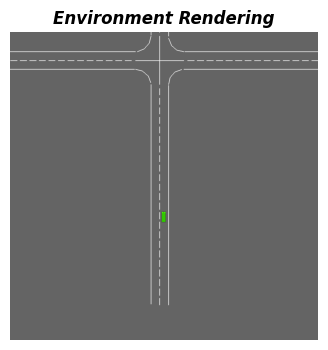

In [302]:
# Let's see only one frame of our Environment
plt.style.use('ggplot')
env.reset()
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(env.render(), cmap='gray')
ax.set_title('Environment Rendering', fontsize=12, fontweight='bold', fontstyle='italic')
ax.axis('off')
plt.show()

### Road Structure

> **Pay Attention** ➡ This cell is only for displaying the *Road Structure* of the environment. (You can skip this section😀)

>**Note:**
>
>The code for nodes in the road network is:
>
>`(o:outer | i:inner + [r:right, l:left]) + (0:south | 1:west | 2:north | 3:east)`
>
>**Inner nodes**: The points in the middle of the intersection where roads meet.
>
>**Outer nodes**: The points where roads enter or exit the intersection.
>
>**Incoming lanes**: Vehicles come **in** to the intersection.
>
>**Exit lanes**: Vehicles go **out** of the intersection.

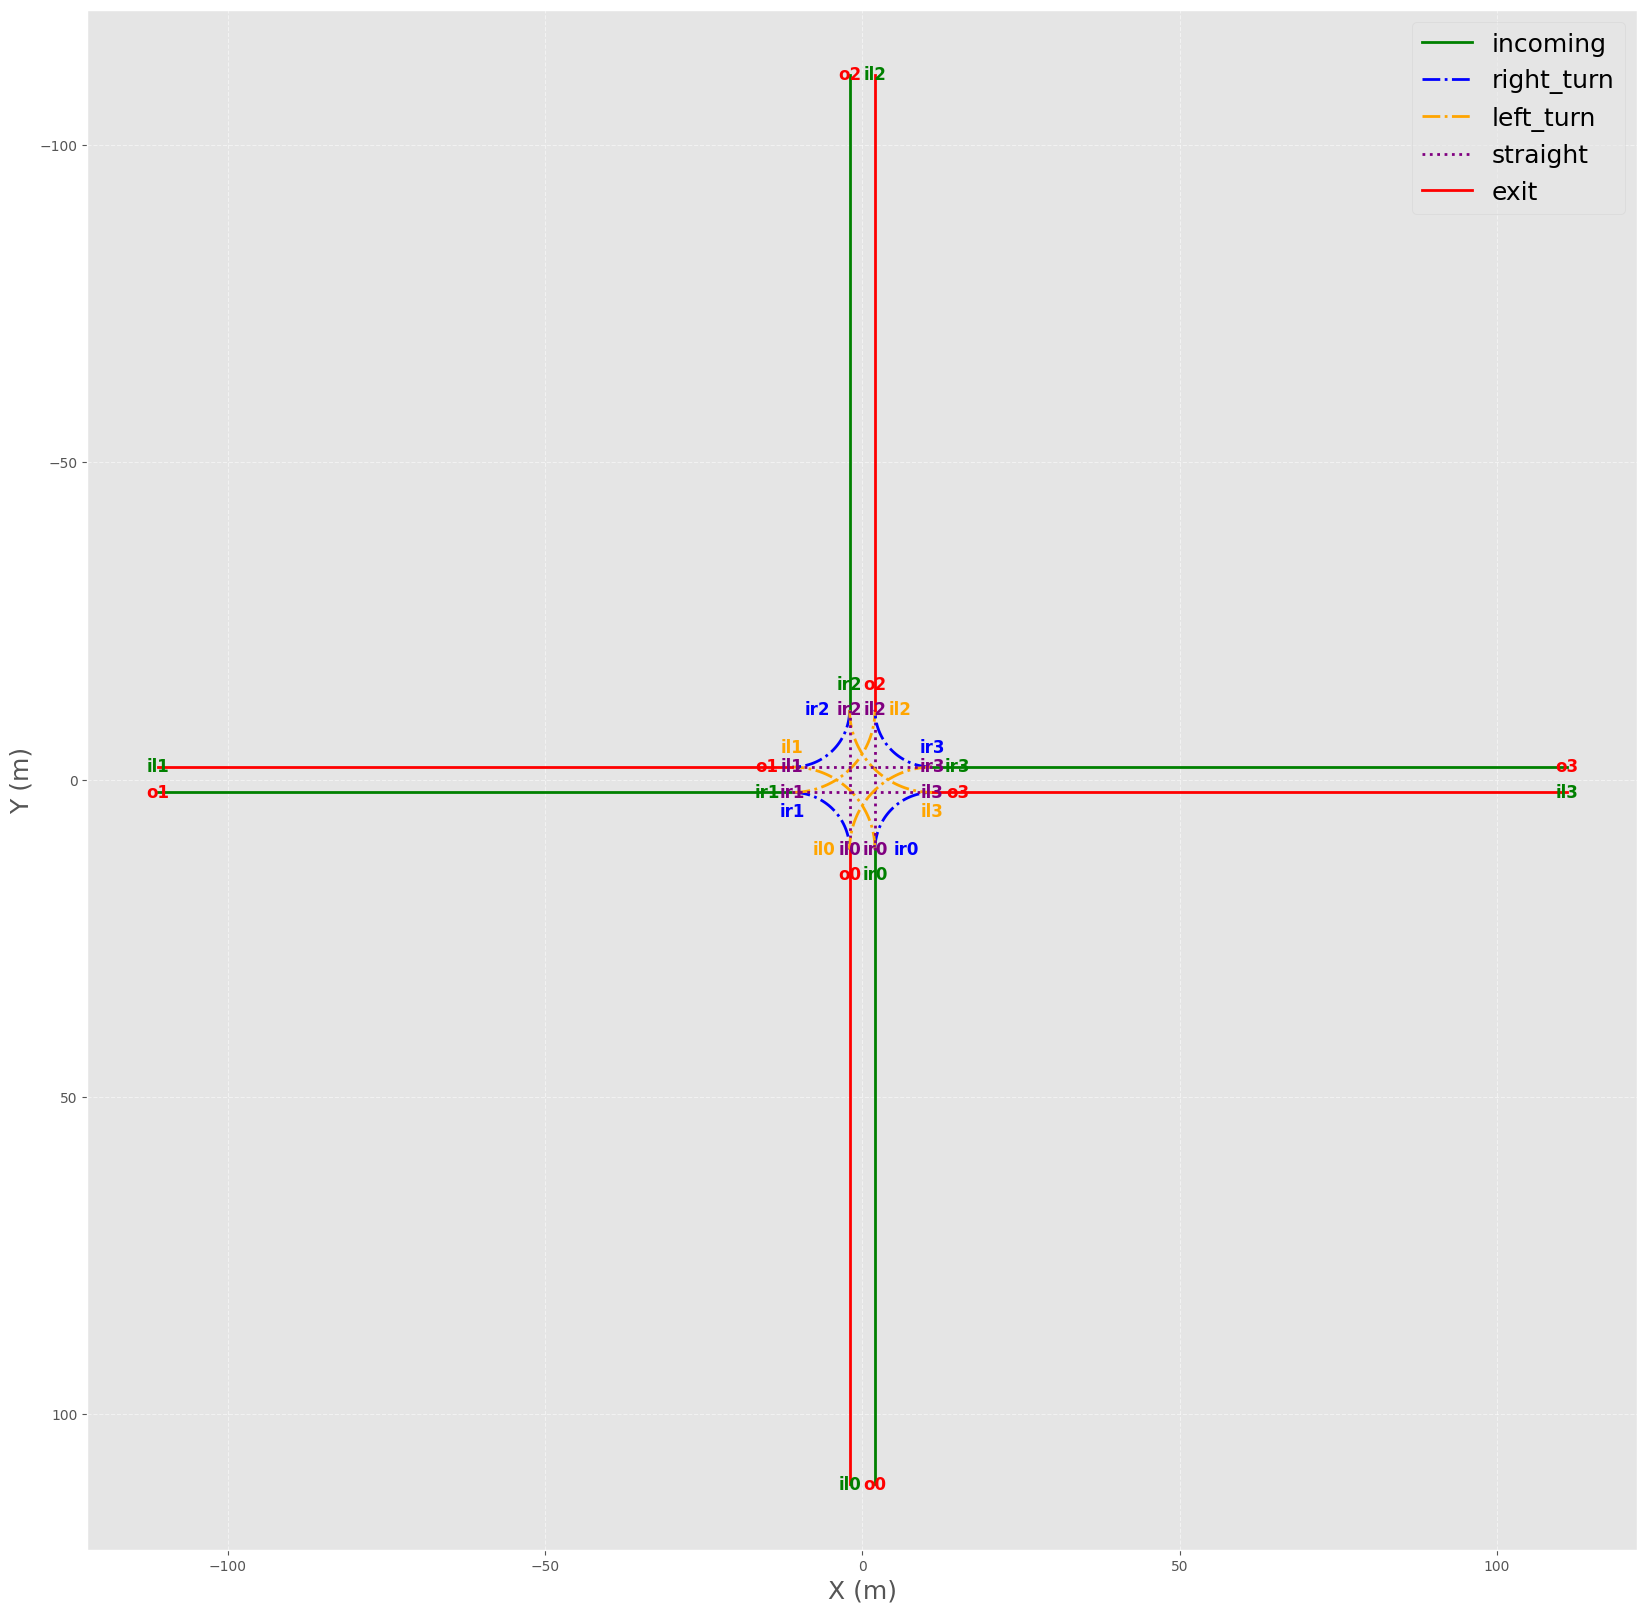

In [303]:
lane_width = 4
right_turn_radius = lane_width + 5
left_turn_radius = right_turn_radius + lane_width
outer_distance = right_turn_radius + lane_width / 2
access_length = 50 + 50

fig, ax = plt.subplots(figsize=(20, 20))

lane_colors = {'incoming': 'g', 'right_turn': 'b', 'left_turn': 'orange', 'straight': 'purple', 'exit': 'r'}
lane_styles = {'incoming': '-', 'right_turn': '-.', 'left_turn': '-.', 'straight': ':', 'exit': '-'}

# Loop over the 4 corners
for corner in range(4):
    angle = np.radians(90 * corner)
    rotation = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

    # Incoming lane
    start = rotation @ np.array([lane_width / 2, access_length + outer_distance])
    end = rotation @ np.array([lane_width / 2, outer_distance])
    ax.plot([start[0], end[0]], [start[1], end[1]], color=lane_colors['incoming'], linestyle=lane_styles['incoming'], linewidth=2, label='Incoming')
    ax.text(start[0], start[1], 'o' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='red')
    if corner==0:
      ax.text(end[0], end[1]+4, 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='g')
    elif corner==1:
      ax.text(end[0]-4, end[1], 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='g')
    elif corner==2:
      ax.text(end[0], end[1]-4, 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='g')
    else:
      ax.text(end[0]+4, end[1], 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='g')

    # Right turn lane
    r_center = rotation @ (np.array([outer_distance, outer_distance]))
    theta = np.linspace(angle + np.radians(180), angle + np.radians(270), 100)
    x = r_center[0] + right_turn_radius * np.cos(theta)
    y = r_center[1] + right_turn_radius * np.sin(theta)
    ax.plot(x, y, color=lane_colors['right_turn'], linestyle=lane_styles['right_turn'], linewidth=2, label='Right Turn')
    if corner==0:
      ax.text(r_center[0]-4, r_center[1], 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='blue')
    elif corner==1:
      ax.text(r_center[0], r_center[1]-6, 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='blue')
    elif corner==2:
      ax.text(r_center[0]+4, r_center[1], 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='blue')
    else:
      ax.text(r_center[0], r_center[1]+6, 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='blue')

    # Left turn lane
    l_center = rotation @ (np.array([-left_turn_radius + lane_width / 2,left_turn_radius - lane_width / 2,]))
    theta = np.linspace(angle + np.radians(0), angle + np.radians(-90), 100)
    x = l_center[0] + left_turn_radius * np.cos(theta)
    y = l_center[1] + left_turn_radius * np.sin(theta)
    ax.plot(x, y, color=lane_colors['left_turn'], linestyle=lane_styles['left_turn'], linewidth=2, label='Left Turn')
    if corner==0:
      ax.text(r_center[0], r_center[1]-6, 'il' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='orange')
    elif corner==1:
      ax.text(r_center[0]+5, r_center[1], 'il' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='orange')
    elif corner==2:
      ax.text(r_center[0], r_center[1]+6, 'il' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='orange')
    else:
      ax.text(r_center[0]-5, r_center[1], 'il' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='orange')

    # Straight lane
    start = rotation @ np.array([lane_width / 2, outer_distance])
    end = rotation @ np.array([lane_width / 2, -outer_distance])
    ax.plot([start[0], end[0]], [start[1], end[1]], color=lane_colors['straight'], linestyle=lane_styles['straight'], linewidth=2, label='Straight')
    ax.text(start[0], start[1], 'ir' + str(corner), ha='center', va='center', fontsize=12, weight='bold', color='purple')
    ax.text(end[0], end[1], 'il' + str((corner + 2) % 4), ha='center', va='center', fontsize=12, weight='bold', color='purple')

    # Exit lane
    start = rotation @ np.flip([lane_width / 2, access_length + outer_distance], axis=0)
    end = rotation @ np.flip([lane_width / 2, outer_distance], axis=0)
    ax.plot([start[0], end[0]], [start[1], end[1]], color=lane_colors['exit'], linestyle=lane_styles['exit'], linewidth=2, label='Exit')
    ax.text(start[0], start[1], 'il' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='green')
    if corner==0:
      ax.text(end[0]+4, end[1], 'o' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='red')
    elif corner==1:
      ax.text(end[0], end[1]+4, 'o' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='red')
    elif corner==2:
      ax.text(end[0]-4, end[1], 'o' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='red')
    else:
      ax.text(end[0], end[1]-4, 'o' + str((corner - 1) % 4), ha='center', va='center', fontsize=12, weight='bold', color='red')

ax.set_xlim(-110, 110)
ax.set_ylim(110, -110)
ax.set_xlabel('X (m)', fontsize=18)
ax.set_ylabel('Y (m)', fontsize=18)
legend_handles = [plt.Line2D([0], [0], color=lane_colors[label], linestyle=lane_styles[label], linewidth=2, label=label) for label in lane_colors.keys()]
ax.legend(handles=legend_handles, loc='upper right', fontsize=18, framealpha=0.5)
ax.grid(True, linestyle='--', alpha=0.5)
ax.axis('equal')
plt.show()


---

# **3-Define DQN Algorithm**

## 3.1- Hyperparameters

In [304]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
𝛼 = 1e-3                # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

## 3.2- Device

In [ ]:
# To determine if the CPU or GPU is available and which one is active now (cuda = GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device.type

## 3.3- Class Neural Network Architecture

### Class Linear

In [306]:
class QNetwork_Linear(nn.Module):

    def __init__(self, state_size, action_size, seed):
        super(QNetwork_Linear, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        # Build a network that maps state -> action values
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # X -> The output vector where each element corresponds to the estimated value (Q-value) of taking each action given the current state.
        return x

## 3.4- Class Replay Buffer

In [307]:
class ReplayBuffer():

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        # Add a new experience to memory
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        # Randomly sample a batch of experiences from memory
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # Return the current size of internal memory
        return len(self.memory)

## 3.5- Class Agent

In [308]:
class Agent():

    def __init__(self, state_size, action_size, network_type, seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.network_type = network_type
        # Q-Network
        self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)

        # Optimizer
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0


    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        #Update value parameters using given batch of experience tuples

        ## Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 𝛼)

    def soft_update(self, local_model, target_model, 𝛼):
        # Soft update model parameters. θ_target = 𝛼*θ_local + (1-𝛼)*θ_target
        ## local_model (PyTorch model): weights will be copied from
        ## target_model (PyTorch model): weights will be copied to
        ## 𝛼 (float): interpolation parameter
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(𝛼*local_param.data + (1-𝛼)*target_param.data)

## 3.6- Class DQN

In [309]:
# Define the function to ensure the directory exists
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

class DQN():
    def __init__(self, env, env_name, model_path, data_path, network_type, env_name_source=None, model_path_source=None, transfer_episode=None):
        self.env = env
        self.env_name = env_name
        self.model_path = model_path
        ensure_directory_exists(self.model_path)
        self.data_path = data_path
        ensure_directory_exists(self.data_path)
        self.network_type = network_type
        self.env_name_source = env_name_source
        self.model_path_source = model_path_source
        self.transfer_episode = transfer_episode
        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        self.env.config['policy_frequency'] = env.config['policy_frequency']

    # If we have state
    def train_with_state(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print("Starting to train agent with state ...")
        if n_iteration[0] != 1:
            self.df_reward = pd.read_excel(self.data_path+'Episodes_reward_run_{}.xlsx'.format(n_iteration[0]-1))

        for iter in tqdm(n_iteration):
            episodes_reward = []
            # Define agent
            # seed for initial random weights of network
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=self.seed[iter-1])
            if (self.env_name_source != None) and (self.model_path_source != None) and (self.transfer_episode != None):
                agent.qnetwork_local.load_state_dict(torch.load(self.model_path_source + 'Models_Run_{}/checkpoint_dqn_state_{}_local_{}.pth'\
                                                                                  .format(iter, self.env_name_source, self.transfer_episode)))
                agent.qnetwork_target.load_state_dict(torch.load(self.model_path_source + 'Models_Run_{}/checkpoint_dqn_state_{}_target_{}.pth'\
                                                                                  .format(iter, self.env_name_source, self.transfer_episode)))
            # initialize epsilon
            eps = eps_start

            for episode_num in tqdm(range(1, n_training_episodes+1)):
                # decrease epsilon
                eps = max(eps_end, eps_decay*eps)
                # get initial state
                state = self.env.reset()[0]

                done = False
                total_rewards_episode = 0
                # repeat
                for step in range(max_step):
                    # Choose action
                    action = agent.act(state.ravel(), eps)
                    # Go to next state and get reward
                    next_state, reward, done, _, _ = self.env.step(action)
                    total_rewards_episode += reward
                    # AGENT STEP FUNCTION
                    agent.step(state.ravel(), action, reward, next_state.ravel(), done)

                    if done:
                        break
                    # Updating State
                    state = next_state
                episodes_reward.append(total_rewards_episode)
                # Printing ...
                print('\rEpisode {}\tAverage reward: {:.2f}\tEpsilon: {:.3f}'.format(episode_num, np.mean(episodes_reward), eps), end='')
                if episode_num % 100 == 0:
                    print('\rEpisode {}\tAverage reward: {:.2f}\tEpsilon: {:.3f}'.format(episode_num, np.mean(episodes_reward), eps))
                if episode_num % 200 == 0:
                    ensure_directory_exists(self.model_path + 'Models_Run_{}/'.format(iter))
                    torch.save(agent.qnetwork_local.state_dict(), self.model_path + 'Models_Run_{}/checkpoint_dqn_state_{}_local_{}.pth'\
                                                                                                .format(iter, self.env_name, episode_num))
                    torch.save(agent.qnetwork_target.state_dict(), self.model_path + 'Models_Run_{}/checkpoint_dqn_state_{}_target_{}.pth'\
                                                                                                .format(iter, self.env_name, episode_num))
            # list of rewards with n_interations * n_episodes dimention
            self.df_reward['Run_{}'.format(iter)] = episodes_reward
            self.df_reward.to_excel(self.data_path+'Episodes_reward_run_{}.xlsx'.format(iter), index=False)
        return self.df_reward

    def evaluation(self, video_path, evaluate_type, iter_num, evaluate_episode_num, use_saved_model=True):

        #vid = video_recorder.VideoRecorder(self.env, path=video_path)
        vid = VideoRecorder(self.env, path=video_path)

        state_size = int(np.prod(self.env.observation_space.shape))
        action_size = self.env.action_space.n
        agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=11)

        if use_saved_model:
            agent.qnetwork_local.load_state_dict(torch.load(self.model_path + 'Models_Run_{}/checkpoint_dqn_{}_{}_local_{}.pth'\
                                .format(iter_num, evaluate_type, self.env_name, evaluate_episode_num), map_location=torch.device(device.type)))
            agent.qnetwork_target.load_state_dict(torch.load(self.model_path + 'Models_Run_{}/checkpoint_dqn_{}_{}_target_{}.pth'\
                                .format(iter_num, evaluate_type, self.env_name, evaluate_episode_num), map_location=torch.device(device.type)))

        state = self.env.reset()[0]
        done = False
        step = 0
        sum_rewards = 0
        while not done:
            print('\rstep:{}'.format(step), end="")

            frame = self.env.render()
            vid.capture_frame()

            action = agent.act(state.ravel())
            state, reward, done, _, _ = self.env.step(action)

            sum_rewards += reward
            step+=1
        print()
        self.env.close()
        return sum_rewards

## 3.7- Class Show and Plot and Video

In [310]:
class show_and_plot():
    def __init__(self):
        pass

    def show_video(self, directory, file_name, width=400, height=400, loop=False, title="The Evaluation Phase Video", fps=30):
      video2 = media.read_video(directory+file_name)
      video2 = media.resize_video(video2, np.array(video2.shape[1:3]) // 2)
      media.show_video(video2,height=height,width=width, fps=fps, codec='h264', loop=loop, border=True, title=title)

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):

        n_iter, n_episode = episodes_rewards.shape

        smooth_reward = []

        for i in range(int(np.round((n_episode-window)/stride))+1):
            k = np.sum(episodes_rewards[:,i*stride:i*stride+window], axis=1) / window
            smooth_reward.append(k)

        smooth_reward = np.array(smooth_reward).T

        _ , n_smooth = smooth_reward.shape

        X =  range(1, stride*n_smooth+1, stride)

        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(n_iter)
        interval =  1 - alpha
        if n_iter < 30:
            t_statistic = t.interval(interval, df = n_iter - 1)[1]
            ME = t_statistic * SE
        else:
            z_statistic = norm.interval(interval)[1]
            ME = z_statistic * SE


        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, (x_bar - ME), (x_bar + ME), alpha=alpha)
        ax.set_xlabel("Episodes", fontsize=12)
        ax.set_ylabel("Average reward", fontsize=12)
        ax.set_title(title + "\nwindow size={}, stride={}".format(window, stride), fontsize=14)
        return ax

class VideoRecorder:
    def __init__(
        self,
        env,
        path: Optional[str] = None,
        metadata: Optional[dict] = None,
        enabled: bool = True,
        base_path: Optional[str] = None,
    ):
        try:
            import moviepy
        except ImportError:
            raise error.DependencyNotInstalled(
                "MoviePy is not installed, run `pip install moviepy`"
            )

        self._async = env.metadata.get("semantics.async")
        self.enabled = enabled
        self._closed = False

        self.render_history = []
        self.env = env

        self.render_mode = env.render_mode

        if "rgb_array_list" != self.render_mode and "rgb_array" != self.render_mode:
            logger.warn(
                f"Disabling video recorder because environment {env} was not initialized with any compatible video "
                "mode between `rgb_array` and `rgb_array_list`"
            )
            self.enabled = False

        if not self.enabled:
            return

        if path is not None and base_path is not None:
            raise error.Error("You can pass at most one of `path` or `base_path`.")

        required_ext = ".mp4"
        if path is None:
            if base_path is not None:
                path = base_path + required_ext
            else:
                with tempfile.NamedTemporaryFile(suffix=required_ext) as f:
                    path = f.name
        self.path = path

        path_base, actual_ext = os.path.splitext(self.path)

        if actual_ext != required_ext:
            raise error.Error(
                f"Invalid path given: {self.path} -- must have file extension {required_ext}."
            )

        self.frames_per_sec = env.metadata.get("render_fps", 30)

        self.broken = False

        self.metadata = metadata or {}
        self.metadata["content_type"] = "video/mp4"
        self.metadata_path = f"{path_base}.meta.json"
        self.write_metadata()

        logger.info(f"Starting new video recorder writing to {self.path}")
        self.recorded_frames = []

    @property
    def functional(self):
        return self.enabled and not self.broken

    def capture_frame(self):
        frame = self.env.render()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        speed = self.env.vehicle.speed
        timer = self.env.time
        cv2.putText(frame, f'Speed: {speed:.2f} m/s', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255) , 2)
        cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), (255, 255, 255), 2)
        if isinstance(frame, List):
            self.render_history += frame
            frame = frame[-1]

        if not self.functional:
            return
        if self._closed:
            logger.warn(
                "The video recorder has been closed and no frames will be captured anymore."
            )
            return
        logger.debug("Capturing video frame: path=%s", self.path)

        if frame is None:
            if self._async:
                return
            else:

                logger.warn(
                    "Env returned None on `render()`. Disabling further rendering for video recorder by marking as "
                    f"disabled: path={self.path} metadata_path={self.metadata_path}"
                )
                self.broken = True
        else:
            self.recorded_frames.append(frame)

    def close(self):
        if not self.enabled or self._closed:
            return

        self.env.close()

        if len(self.recorded_frames) > 0:
            try:
                from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
            except ImportError:
                raise error.DependencyNotInstalled(
                    "MoviePy is not installed, run `pip install moviepy`"
                )

            logger.debug(f"Closing video encoder: path={self.path}")
            clip = ImageSequenceClip(self.recorded_frames, fps=self.frames_per_sec)
            clip.write_videofile(self.path)
        else:
            if self.metadata is None:
                self.metadata = {}
            self.metadata["empty"] = True

        self.write_metadata()

        self._closed = True

    def write_metadata(self):
        with open(self.metadata_path, "w") as f:
            json.dump(self.metadata, f)

    def __del__(self):
        self.close()



---



# 4- Intersection Scenarios

In [311]:
video_path = '/content/drive/MyDrive/HRRahmaniThesis/Videos/Intersection/'
image_path = '/content/drive/MyDrive/HRRahmaniThesis/Images/Intersection/'
model_path = '/content/drive/MyDrive/HRRahmaniThesis/Models/Intersection/'
data_path = '/content/drive/MyDrive/HRRahmaniThesis/Data_Average_Reward/Intersection/'

## 4.1- Scenraio-1 **Brake** 🛑

In [ ]:
env_name = 'intersection-v0'
env1 = IntersectionEnv()
#--------------------------------
# Scenario-1 Configuration
env1.config["choose_start_lane"] = True
env1.config["start_lane"] = ("o0","ir0",0)
env1.config["position_in_lane"] = [10,0]
env1.config['initial_ego_speed'] = 0
env1.config["destination"] = "ir0"
env1.config["destination_type"] = "ir"
env1.config["destination_distance"] = 3 #Don't change it
# *** *** *** *** *** *** *** ***
env1.config["Enabale_standing_vehicle"] = False
# *** *** *** *** *** *** *** ***
env1.config["Enabale_random_vehicle"] = False
env1.render_mode = 'rgb_array'
env1.reset()
#--------------------------------
# print the ego-vehicle route based the chosen start lane and destination
route = [item[:2] for item in env1.vehicle.route]
route_str = "] ⏭️ [".join(f"{start} ➡️ {end}" for start, end in route)
print(f"\nRoute: [{route_str}]\n")
#--------------------------------
# Get ready :)
dqn_Intersection = DQN(env1, env_name, model_path + '_Scenario_1/', data_path + '_Scenario_1/', network_type='linear')

### Training

In [ ]:
df_reward_dqn_Intersection = dqn_Intersection.train_with_state(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=2000, max_step=100)

### Evaluating

In [ ]:
from gym.envs.registration import EnvSpec
ensure_directory_exists(video_path)
dqn_Intersection.env.spec = EnvSpec(id='intersection-v0')
dqn_Intersection.env.config['policy_frequency'] = 1
dqn_Intersection.env.config['simulation_frequency'] = 15
sum_rewards = dqn_Intersection.evaluation(video_path+"_Scenario_1.mp4",evaluate_type='state',iter_num=2,evaluate_episode_num=2000,use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

In [ ]:
show_and_plot().show_video(directory=video_path, file_name="_Scenario_1.mp4", fps=24, title="The Evaluation Phase Video - Scenario 1")

### Plotting

In [ ]:
df_reward_dqn_intersection = pd.read_excel(data_path + '_Scenario_1/' + 'Episodes_reward_run_5.xlsx')
episodes_rewards_intersection = df_reward_dqn_intersection.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_intersection, ax, title='DQN', label='Scenario 1', window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
ensure_directory_exists(image_path)
fig.savefig(image_path+'_Scenario_1.png', dpi=300)



---



## 4.2- Scenraio-2 **Braking Behind Another Car** 🛑🚙

In [ ]:
env_name = 'intersection-v0'
env2 = IntersectionEnv()
#--------------------------------
# Scenario-2 Configuration
env2.config["choose_start_lane"] = True
env2.config["start_lane"] = ("o0","ir0",0)
env2.config["position_in_lane"] = [10,0]
env2.config['initial_ego_speed'] = 0
env2.config["destination"] = "ir0"
env2.config["destination_type"] = "ir"
env2.config["destination_distance"] = 5 #Don't change it
# *** *** *** *** *** *** *** ***
env2.config["Enabale_standing_vehicle"] = True
env2.config["SV_lane_index"] = ("o0","ir0",0)
env2.config["SV_lon_position"] = 100
# *** *** *** *** *** *** *** ***
env2.config["Enabale_random_vehicle"] = False
env2.render_mode = 'rgb_array'
env2.reset()
#--------------------------------
# print the ego-vehicle route based the chosen start lane and destination
route = [item[:2] for item in env2.vehicle.route]
route_str = "] ⏭️ [".join(f"{start} ➡️ {end}" for start, end in route)
print(f"\nRoute: [{route_str}]\n")
#--------------------------------
# Get ready :)
dqn_Intersection = DQN(env2, env_name, model_path + '_Scenario_2/', data_path + '_Scenario_2/', network_type='linear')

### Training

In [ ]:
df_reward_dqn_Intersection = dqn_Intersection.train_with_state(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=2000, max_step=100)

### Evaluating

In [ ]:
from gym.envs.registration import EnvSpec
ensure_directory_exists(video_path)
dqn_Intersection.env.spec = EnvSpec(id='intersection-v0')
dqn_Intersection.env.config['policy_frequency'] = 1
dqn_Intersection.env.config['simulation_frequency'] = 15
sum_rewards = dqn_Intersection.evaluation(video_path+"_Scenario_2.mp4",evaluate_type='state',iter_num=1,evaluate_episode_num=2000,use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

In [ ]:
show_and_plot().show_video(directory=video_path, file_name="_Scenario_2.mp4", fps=24, title="The Evaluation Phase Video - Scenario 2")

### Plotting

In [ ]:
df_reward_dqn_intersection = pd.read_excel(data_path + '_Scenario_2/' + 'Episodes_reward_run_5.xlsx')
episodes_rewards_intersection = df_reward_dqn_intersection.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_intersection, ax, title='DQN', label='Scenario 2', window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
ensure_directory_exists(image_path)
fig.savefig(image_path+'_Scenario_2.png', dpi=300)

In [ ]:
df_reward_dqn_intersection_S1 = pd.read_excel(data_path + '_Scenario_1/' + 'Episodes_reward_run_5.xlsx')
episodes_rewards_intersection_S1 = df_reward_dqn_intersection_S1.T.to_numpy()
df_reward_dqn_intersection_S2 = pd.read_excel(data_path + '_Scenario_2/' + 'Episodes_reward_run_5.xlsx')
episodes_rewards_intersection_S2 = df_reward_dqn_intersection_S2.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_intersection_S1, ax, title='DQN', label='Scenario 1', window=50, stride=10, alpha=0.3)
ax = show_and_plot().plot_training_result(episodes_rewards_intersection_S2, ax, title='DQN', label='Scenario 2', window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
ensure_directory_exists(image_path)
fig.savefig(image_path+'_Scenario_1_and_2.png', dpi=300)



---



## 4.3- Scenraio-3 **Turning** 🚙⤴

In [ ]:
env_name = 'intersection-v0'
env3 = IntersectionEnv()
#--------------------------------
# Scenario-3 Configuration
env3.config["choose_start_lane"] = True
env3.config["start_lane"] = ("o0","ir0",0)
env3.config["position_in_lane"] = [70,0]
env3.config['initial_ego_speed'] = 0
env3.config["destination"] = "o1"
env3.config["destination_type"] = "o"
env3.config["destination_distance"] = 80 #Don't change it
# *** *** *** *** *** *** *** ***
env3.config["Enabale_standing_vehicle"] = False
env3.config["Enabale_random_vehicle"] = False
# *** *** *** *** *** *** *** ***
env3.render_mode = 'rgb_array'
env3.reset()
#--------------------------------
# print the ego-vehicle route based the chosen start lane and destination
route = [item[:2] for item in env3.vehicle.route]
route_str = "] ⏭️ [".join(f"{start} ➡️ {end}" for start, end in route)
print(f"\nRoute: [{route_str}]\n")
#--------------------------------
# Get ready :)
dqn_Intersection = DQN(env3, env_name, model_path + '_Scenario_3/', data_path + '_Scenario_3/', network_type='linear')

### Training

In [ ]:
df_reward_dqn_Intersection = dqn_Intersection.train_with_state(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=2000, max_step=100)

### Evaluating

In [ ]:
from gym.envs.registration import EnvSpec
ensure_directory_exists(video_path)
dqn_Intersection.env.spec = EnvSpec(id='intersection-v0')
dqn_Intersection.env.config['policy_frequency'] = 1
dqn_Intersection.env.config['simulation_frequency'] = 15
sum_rewards = dqn_Intersection.evaluation(video_path+"_Scenario_3.mp4",evaluate_type='state',iter_num=1,evaluate_episode_num=2000,use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

In [ ]:
show_and_plot().show_video(directory=video_path, file_name="_Scenario_3.mp4", fps=24, title="The Evaluation Phase Video - Scenario 3")

### Plotting

In [ ]:
df_reward_dqn_intersection = pd.read_excel(data_path + '_Scenario_3/' + 'Episodes_reward_run_5.xlsx')
episodes_rewards_intersection = df_reward_dqn_intersection.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_intersection, ax, title='DQN', label='Scenario 3', window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
ensure_directory_exists(image_path)
fig.savefig(image_path+'_Scenario_3.png', dpi=300)



---



## 4.4- Scenraio-4 **Overtaking** 🚙🚓

In [ ]:
env_name = 'intersection-v0'
env4 = IntersectionEnvScenario4()
#--------------------------------
# Scenario-4 Configuration
env4.config["choose_start_lane"] = True
env4.config['Overtaking_modification'] = True
env4.config["start_lane"] = ("o0","ir0",0)
env4.config["position_in_lane"] = [10,0]
env4.config['initial_ego_speed'] = 0
env4.config["destination"] = "ir0"
env4.config["destination_type"] = "ir"
env4.config["destination_distance"] = 5 #Don't change it
# *** *** *** *** *** *** *** ***
env4.config["Enabale_standing_vehicle"] = True
env4.config["SV_lane_index"] = ("o0","ir0",0)
env4.config["SV_lon_position"] = 60
# *** *** *** *** *** *** *** ***
env4.config["Enabale_random_vehicle"] = False
#--------------------------------
env4.render_mode = 'rgb_array'
env4.reset()
#--------------------------------
# print the ego-vehicle route based the chosen start lane and destination
route = [item[:2] for item in env4.vehicle.route]
route_str = "] ⏭️ [".join(f"{start} ➡️ {end}" for start, end in route)
print(f"\nRoute: [{route_str}]\n")
#--------------------------------
# Get ready :)
dqn_Intersection = DQN(env4, env_name, model_path + '_Scenario_4/', data_path + '_Scenario_4/', network_type='linear')

### Training

In [ ]:
df_reward_dqn_Intersection = dqn_Intersection.train_with_state(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=2000, max_step=100)

### Evaluating

In [ ]:
from gym.envs.registration import EnvSpec
ensure_directory_exists(video_path)
dqn_Intersection.env.spec = EnvSpec(id='intersection-v0')
dqn_Intersection.env.config['policy_frequency'] = 1
dqn_Intersection.env.config['simulation_frequency'] = 15
sum_rewards = dqn_Intersection.evaluation(video_path+"_Scenario_4.mp4",evaluate_type='state',iter_num=1,evaluate_episode_num=2000,use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

In [ ]:
show_and_plot().show_video(directory=video_path, file_name="_Scenario_4.mp4", fps=8, title="The Evaluation Phase Video - Scenario 4")

### Plotting

In [ ]:
df_reward_dqn_intersection = pd.read_excel(data_path + '_Scenario_4/' + 'Episodes_reward_run_5.xlsx')
episodes_rewards_intersection = df_reward_dqn_intersection.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_intersection, ax, title='DQN', label='Scenario 4', window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
ensure_directory_exists(image_path)
fig.savefig(image_path+'_Scenario_4.png', dpi=300)



---

